# WeGo Public Transit
[WeGo Public Transit](https://www.wegotransit.com/) is a public transit system serving the Greater Nashville and Davidson County area. WeGo provides local and regional bus routes, the WeGo Star train service connecting Lebanon to downtown Nashville, along with several other transit services.

The data for this project can be downloaded from [here](https://drive.google.com/file/d/1iM4WjC9k3EXHPNc6q4AwDh_MEIpXvfMD/view?usp=sharing).

In this project, you'll be analyzing the bus spacing to look for patterns and try to identify correlations to controllable or external factors. Specifically, you'll be using a dataset containing information on the headway, or amount of time between vehicle arrivals at a stop. 

There are two main variables you will be studying in this project, headway deviation and adherence.

**<u>Headway</u>** is the amount of time between a bus and the prior bus at the same stop. In the dataset, the amount of headway scheduled is contained in the <u>SCHEDULED_HDWY</u> column and indicates the difference between the scheduled time for a particular stop and the scheduled time for the previous bus on that same stop. This dataset contains a column <u>HDWY_DEV</u>, which shows the amount of deviation from the scheduled headway. 

**<u>Bunching</u>** occurs when there is shorter headway than scheduled, which would appear as a negative HDWY_DEV value. 

**<u>Gapping</u>** is when there is more headway than scheduled and appears as a positive value in the HDWY_DEV column. Note that you can calculate headway deviation percentage as HDWY_DEV/SCHEDULED_HDWY. The generally accepted range of headway deviation is 50% to 150% of the scheduled headway, so if scheduled headway is 10 minutes, a headway deviation of up to 5 minutes would be acceptable (but not ideal).

Another important variable is **<u>adherence</u>**, which compares the actual departure time to the scheduled time and is included in the ADHERENCE column. A negative adherence value means that a bus left a time point late and a positive adherence indicates that the bus left the time point early. Buses with adherence values beyond negative 6 are generally considered late and beyond positive 1 are considered early. However, there is some additional logic where the staff applies waivers to allow early departures, such as an express bus that has already picked up everyone at a park-and-ride lot and is only dropping people off at the remaining stops, and also allows for early timepoint records for all records where TRIP_EDGE = 2 (end of trip), since it is not a problem if a bus ends its trip early as long as it didn't pass other timepoints early along the way. 

**Note:** When determining whether a bus is early or late, it is advised that you use the 'ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT', and 'ADJUSTED_ONTIME_COUNT' columns in order to account for the adjustments.

5. Is there any relationship between lateness (ADHERENCE) and headway deviation?

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
pd.set_option('display.max_columns', None) #allows me to see all columns in a datafram

In [31]:
# import data and make all column titles lowercase
wego = pd.read_csv('../data/Headway Data, 8-1-2023 to 9-30-2023.csv')
wego.columns = [x.lower() for x in wego.columns]
wego.head()

,calendar_id,service_abbr,adherence_id,date,route_abbr,block_abbr,operator,trip_id,overload_id,route_direction_name,time_point_abbr,route_stop_sequence,trip_edge,latitude,longitude,scheduled_time,actual_arrival_time,actual_departure_time,adherence,scheduled_hdwy,actual_hdwy,hdwy_dev,adjusted_early_count,adjusted_late_count,adjusted_ontime_count,stop_cancelled,prev_sched_stop_cancelled,is_relief,dwell_in_mins,scheduled_layover_minutes
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,MHSP,14.0,1,36.181248,-86.847705,2023-08-01 04:42:00,2023-08-01 04:37:38,2023-08-01 04:44:08,-2.133333,NaN,NaN,NaN,0,0,1,0,0.0,0,6.500000,NaN
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,ELIZ,10.0,0,36.193454,-86.839981,2023-08-01 04:46:00,2023-08-01 04:48:27,2023-08-01 04:48:27,-2.450000,NaN,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,CV23,5.0,0,36.182177,-86.814445,2023-08-01 04:54:00,2023-08-01 04:54:56,2023-08-01 04:54:56,-0.933333,NaN,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,MCC5_10,1.0,2,36.167091,-86.781923,2023-08-01 05:10:00,2023-08-01 05:03:43,2023-08-01 05:03:43,6.283333,NaN,NaN,NaN,0,0,1,0,NaN,0,0.000000,NaN
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,MCC5_10,1.0,1,36.167091,-86.781923,2023-08-01 05:15:00,2023-08-01 05:03:43,2023-08-01 05:16:35,-1.583333,NaN,NaN,NaN,0,0,1,0,0.0,0,12.866666,5.0


In [32]:
# dropped all NaN values from hdwy_dev column
wego_clean = wego.dropna(subset=['hdwy_dev']).reset_index()
wego_clean.head()

,index,calendar_id,service_abbr,adherence_id,date,route_abbr,block_abbr,operator,trip_id,overload_id,route_direction_name,time_point_abbr,route_stop_sequence,trip_edge,latitude,longitude,scheduled_time,actual_arrival_time,actual_departure_time,adherence,scheduled_hdwy,actual_hdwy,hdwy_dev,adjusted_early_count,adjusted_late_count,adjusted_ontime_count,stop_cancelled,prev_sched_stop_cancelled,is_relief,dwell_in_mins,scheduled_layover_minutes
0,7,120230801,1,99457897,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,MHSP,14.0,1,36.181248,-86.847705,2023-08-01 05:42:00,2023-08-01 05:30:30,2023-08-01 05:43:43,-1.716666,35.0,37.666666,2.666666,0,0,1,0,0.0,0,13.216666,10.0
1,8,120230801,1,99457898,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,ELIZ,10.0,0,36.193454,-86.839981,2023-08-01 05:46:00,2023-08-01 05:47:55,2023-08-01 05:47:55,-1.916666,35.0,36.966666,1.966666,0,0,1,0,0.0,0,0.000000,NaN
2,9,120230801,1,99457899,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,CV23,5.0,0,36.182177,-86.814445,2023-08-01 05:54:00,2023-08-01 05:54:11,2023-08-01 05:54:11,-0.183333,15.0,14.516666,-0.483334,0,0,1,0,0.0,0,0.000000,NaN
3,11,120230801,1,99457901,2023-08-01,22,2200,1040,345107,0,FROM DOWNTOWN,MCC5_10,1.0,1,36.167091,-86.781923,2023-08-01 06:15:00,2023-08-01 06:05:31,2023-08-01 06:16:19,-1.316666,15.0,12.833333,-2.166667,0,0,1,0,0.0,0,10.800000,5.0
4,12,120230801,1,99457902,2023-08-01,22,2200,1040,345107,0,FROM DOWNTOWN,CV23,5.0,0,36.183480,-86.814220,2023-08-01 06:25:00,2023-08-01 06:23:30,2023-08-01 06:23:30,1.500000,15.0,11.116666,-3.883334,1,0,0,0,0.0,0,0.000000,NaN


In [33]:
# filter out adherence and hdwy_dev values that seem to be outliers
wego_clean1 = wego.dropna(subset=['hdwy_dev']).reset_index()
wego_clean = wego_clean1[wego_clean1['adherence'].between(-25, 10)]
wego_clean = wego_clean[wego_clean['hdwy_dev'].between(-20,40)]
wego_clean.head()

,index,calendar_id,service_abbr,adherence_id,date,route_abbr,block_abbr,operator,trip_id,overload_id,route_direction_name,time_point_abbr,route_stop_sequence,trip_edge,latitude,longitude,scheduled_time,actual_arrival_time,actual_departure_time,adherence,scheduled_hdwy,actual_hdwy,hdwy_dev,adjusted_early_count,adjusted_late_count,adjusted_ontime_count,stop_cancelled,prev_sched_stop_cancelled,is_relief,dwell_in_mins,scheduled_layover_minutes
0,7,120230801,1,99457897,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,MHSP,14.0,1,36.181248,-86.847705,2023-08-01 05:42:00,2023-08-01 05:30:30,2023-08-01 05:43:43,-1.716666,35.0,37.666666,2.666666,0,0,1,0,0.0,0,13.216666,10.0
1,8,120230801,1,99457898,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,ELIZ,10.0,0,36.193454,-86.839981,2023-08-01 05:46:00,2023-08-01 05:47:55,2023-08-01 05:47:55,-1.916666,35.0,36.966666,1.966666,0,0,1,0,0.0,0,0.000000,NaN
2,9,120230801,1,99457899,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,CV23,5.0,0,36.182177,-86.814445,2023-08-01 05:54:00,2023-08-01 05:54:11,2023-08-01 05:54:11,-0.183333,15.0,14.516666,-0.483334,0,0,1,0,0.0,0,0.000000,NaN
3,11,120230801,1,99457901,2023-08-01,22,2200,1040,345107,0,FROM DOWNTOWN,MCC5_10,1.0,1,36.167091,-86.781923,2023-08-01 06:15:00,2023-08-01 06:05:31,2023-08-01 06:16:19,-1.316666,15.0,12.833333,-2.166667,0,0,1,0,0.0,0,10.800000,5.0
4,12,120230801,1,99457902,2023-08-01,22,2200,1040,345107,0,FROM DOWNTOWN,CV23,5.0,0,36.183480,-86.814220,2023-08-01 06:25:00,2023-08-01 06:23:30,2023-08-01 06:23:30,1.500000,15.0,11.116666,-3.883334,1,0,0,0,0.0,0,0.000000,NaN


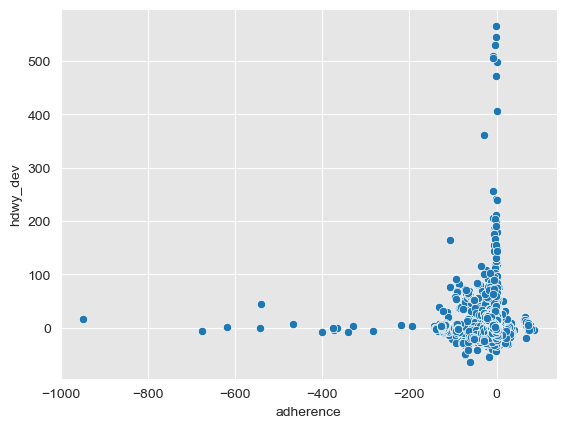

In [34]:
#Scatterplot before removing outliers.
sns.scatterplot(x=wego_clean1['adherence'], y=wego_clean1['hdwy_dev'])
plt.xlabel('adherence')
plt.ylabel('hdwy_dev')
plt.show()

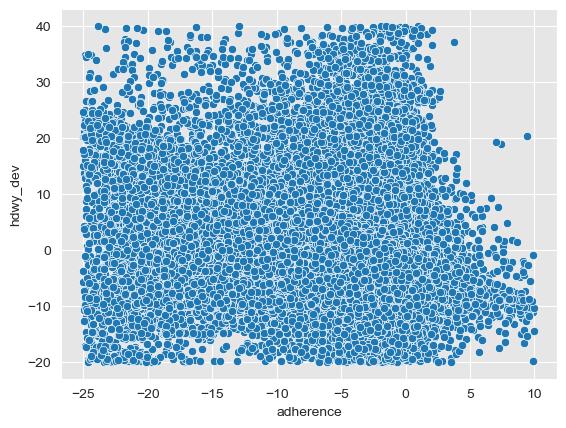

In [35]:
#Scatterplot after removing outliers.
sns.scatterplot(x=wego_clean['adherence'], y=wego_clean['hdwy_dev'])
plt.xlabel('adherence')
plt.ylabel('hdwy_dev')
plt.show()

In [36]:
#Prints correlation coefficient to show strength of relationship between headway deviation and adherence.
correlation_coefficient = wego_clean['hdwy_dev'].corr(wego_clean['adherence'])
print(correlation_coefficient)

-0.39569764914508887


In [37]:
# create a column that has the average adherence per route
adherence_mean_serie = wego_clean.groupby('route_abbr')['adherence'].mean()
wego_clean['mean_adherence'] = wego_clean['route_abbr'].map(adherence_mean_serie)
wego_clean.head()

,index,calendar_id,service_abbr,adherence_id,date,route_abbr,block_abbr,operator,trip_id,overload_id,route_direction_name,time_point_abbr,route_stop_sequence,trip_edge,latitude,longitude,scheduled_time,actual_arrival_time,actual_departure_time,adherence,scheduled_hdwy,actual_hdwy,hdwy_dev,adjusted_early_count,adjusted_late_count,adjusted_ontime_count,stop_cancelled,prev_sched_stop_cancelled,is_relief,dwell_in_mins,scheduled_layover_minutes,mean_adherence
0,7,120230801,1,99457897,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,MHSP,14.0,1,36.181248,-86.847705,2023-08-01 05:42:00,2023-08-01 05:30:30,2023-08-01 05:43:43,-1.716666,35.0,37.666666,2.666666,0,0,1,0,0.0,0,13.216666,10.0,-2.01569
1,8,120230801,1,99457898,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,ELIZ,10.0,0,36.193454,-86.839981,2023-08-01 05:46:00,2023-08-01 05:47:55,2023-08-01 05:47:55,-1.916666,35.0,36.966666,1.966666,0,0,1,0,0.0,0,0.000000,NaN,-2.01569
2,9,120230801,1,99457899,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,CV23,5.0,0,36.182177,-86.814445,2023-08-01 05:54:00,2023-08-01 05:54:11,2023-08-01 05:54:11,-0.183333,15.0,14.516666,-0.483334,0,0,1,0,0.0,0,0.000000,NaN,-2.01569
3,11,120230801,1,99457901,2023-08-01,22,2200,1040,345107,0,FROM DOWNTOWN,MCC5_10,1.0,1,36.167091,-86.781923,2023-08-01 06:15:00,2023-08-01 06:05:31,2023-08-01 06:16:19,-1.316666,15.0,12.833333,-2.166667,0,0,1,0,0.0,0,10.800000,5.0,-2.01569
4,12,120230801,1,99457902,2023-08-01,22,2200,1040,345107,0,FROM DOWNTOWN,CV23,5.0,0,36.183480,-86.814220,2023-08-01 06:25:00,2023-08-01 06:23:30,2023-08-01 06:23:30,1.500000,15.0,11.116666,-3.883334,1,0,0,0,0.0,0,0.000000,NaN,-2.01569


In [38]:
# create a column that has the average headway deviation per route
headway_mean_serie = wego_clean.groupby('route_abbr')['hdwy_dev'].mean()
wego_clean['mean_hdwy_dev'] = wego_clean['route_abbr'].map(headway_mean_serie)
wego_clean.head()

,index,calendar_id,service_abbr,adherence_id,date,route_abbr,block_abbr,operator,trip_id,overload_id,route_direction_name,time_point_abbr,route_stop_sequence,trip_edge,latitude,longitude,scheduled_time,actual_arrival_time,actual_departure_time,adherence,scheduled_hdwy,actual_hdwy,hdwy_dev,adjusted_early_count,adjusted_late_count,adjusted_ontime_count,stop_cancelled,prev_sched_stop_cancelled,is_relief,dwell_in_mins,scheduled_layover_minutes,mean_adherence,mean_hdwy_dev
0,7,120230801,1,99457897,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,MHSP,14.0,1,36.181248,-86.847705,2023-08-01 05:42:00,2023-08-01 05:30:30,2023-08-01 05:43:43,-1.716666,35.0,37.666666,2.666666,0,0,1,0,0.0,0,13.216666,10.0,-2.01569,0.395173
1,8,120230801,1,99457898,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,ELIZ,10.0,0,36.193454,-86.839981,2023-08-01 05:46:00,2023-08-01 05:47:55,2023-08-01 05:47:55,-1.916666,35.0,36.966666,1.966666,0,0,1,0,0.0,0,0.000000,NaN,-2.01569,0.395173
2,9,120230801,1,99457899,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,CV23,5.0,0,36.182177,-86.814445,2023-08-01 05:54:00,2023-08-01 05:54:11,2023-08-01 05:54:11,-0.183333,15.0,14.516666,-0.483334,0,0,1,0,0.0,0,0.000000,NaN,-2.01569,0.395173
3,11,120230801,1,99457901,2023-08-01,22,2200,1040,345107,0,FROM DOWNTOWN,MCC5_10,1.0,1,36.167091,-86.781923,2023-08-01 06:15:00,2023-08-01 06:05:31,2023-08-01 06:16:19,-1.316666,15.0,12.833333,-2.166667,0,0,1,0,0.0,0,10.800000,5.0,-2.01569,0.395173
4,12,120230801,1,99457902,2023-08-01,22,2200,1040,345107,0,FROM DOWNTOWN,CV23,5.0,0,36.183480,-86.814220,2023-08-01 06:25:00,2023-08-01 06:23:30,2023-08-01 06:23:30,1.500000,15.0,11.116666,-3.883334,1,0,0,0,0.0,0,0.000000,NaN,-2.01569,0.395173


In [39]:
# creating a list of route names to title each plot
abbr_route = {1: 'Route 3',
             2: 'Route 7',
             3: 'Route 22',
             4: 'Route 23',
             5: 'Route 50',
             6: 'Route 52',
             7: 'Route 55',
             8: 'Route 56'}
             

Ridgeline for adherence

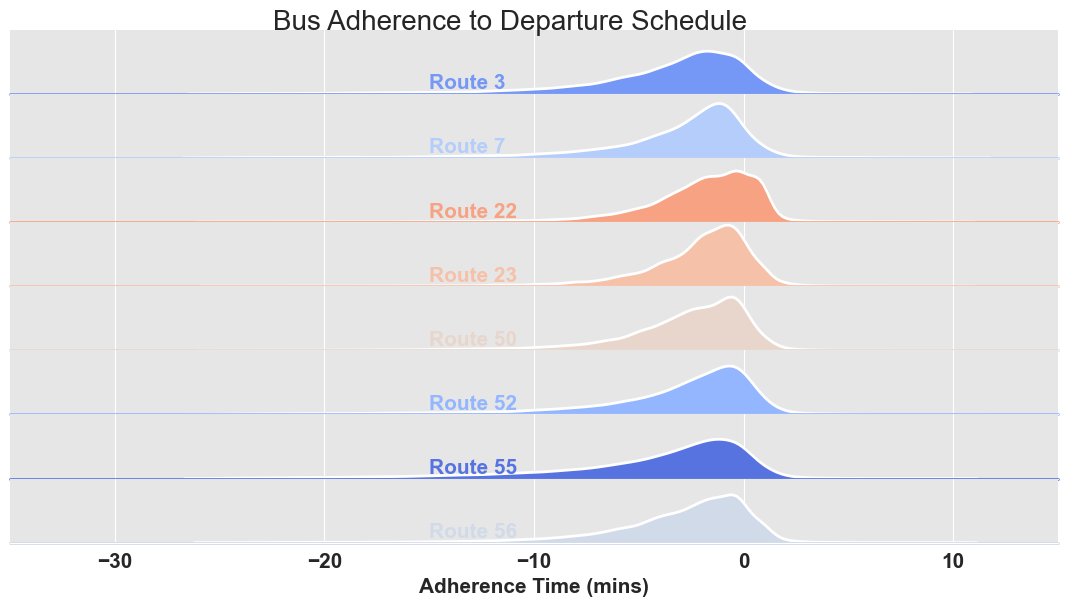

In [40]:
# we generate a color palette with Seaborn.color_palette()
pal = sns.color_palette(palette='coolwarm', n_colors=10)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# in the sns.FacetGrid class, the 'hue' argument is the one that is the one that will be represented by colors with 'palette'
g = sns.FacetGrid(wego_clean, row='route_abbr', hue='mean_adherence', aspect=15, height=0.75, palette=pal)

# then we add the densities kdeplots for each month
g.map(sns.kdeplot, 'adherence',
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)

# here we add a white line that represents the contour of each kdeplot
g.map(sns.kdeplot, 'adherence', 
      bw_adjust=1, clip_on=False, 
      color="w", lw=2)

# here we add a horizontal line for each plot
g.map(plt.axhline, y=0,
      lw=2, clip_on=False)

# we loop over the FacetGrid figure axes (g.axes.flat) and add the month as text with the right color
# notice how ax.lines[-1].get_color() enables you to access the last line's color in each matplotlib.Axes
for i, ax in enumerate(g.axes.flat):
    ax.set_xlim(-35, 15)
    ax.text(-15, 0.02, abbr_route[i+1],
            fontweight='bold', fontsize=15,
            color=ax.lines[-1].get_color())
    
# we use matplotlib.Figure.subplots_adjust() function to get the subplots to overlap
g.fig.subplots_adjust(hspace=0.0)

# eventually we remove axes titles, yticks and spines
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=False, left=True)

plt.setp(ax.get_xticklabels(), fontsize=15, fontweight='bold')
plt.xlabel('Adherence Time (mins)', fontweight='bold', fontsize=15)
g.fig.suptitle('Bus Adherence to Departure Schedule',
               ha='center',
               fontsize=20,
               fontweight=20)

# plt.figure(figsize=(10, 10))
plt.show()

# g.savefig("ridgeline.png")

Ridgeline for headway deviation

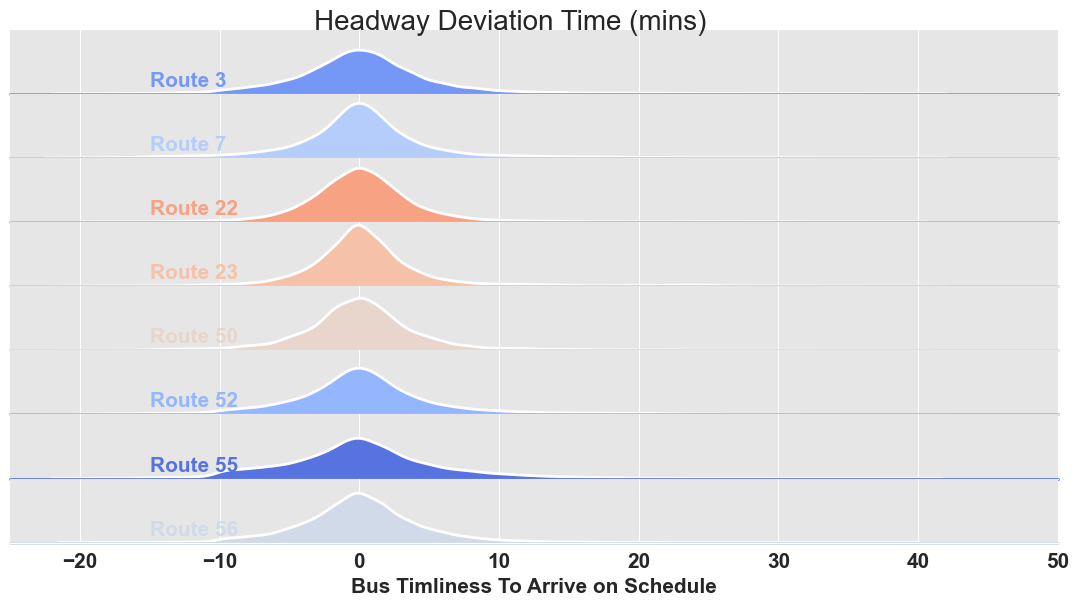

In [41]:
# we generate a color palette with Seaborn.color_palette()
pal = sns.color_palette(palette='coolwarm', n_colors=10)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# in the sns.FacetGrid class, the 'hue' argument is the one that is the one that will be represented by colors with 'palette'
g = sns.FacetGrid(wego_clean, row='route_abbr', hue='mean_adherence', aspect=15, height=0.75, palette=pal)

# then we add the densities kdeplots for each month
g.map(sns.kdeplot, 'hdwy_dev',
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)

# here we add a white line that represents the contour of each kdeplot
g.map(sns.kdeplot, 'hdwy_dev', 
      bw_adjust=1, clip_on=False, 
      color="w", lw=2)

# here we add a horizontal line for each plot
g.map(plt.axhline, y=0,
      lw=2, clip_on=False)

# we loop over the FacetGrid figure axes (g.axes.flat) and add the month as text with the right color
# notice how ax.lines[-1].get_color() enables you to access the last line's color in each matplotlib.Axes
for i, ax in enumerate(g.axes.flat):
    ax.set_xlim(-25, 50)
    ax.text(-15, 0.02, abbr_route[i+1],
            fontweight='bold', fontsize=15,
            color=ax.lines[-1].get_color())
    
# we use matplotlib.Figure.subplots_adjust() function to get the subplots to overlap
g.fig.subplots_adjust(hspace=0.0)

# eventually we remove axes titles, yticks and spines
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=False, left=True)

plt.setp(ax.get_xticklabels(), fontsize=15, fontweight='bold')
plt.xlabel('Bus Timliness To Arrive on Schedule', fontweight='bold', fontsize=15)
g.fig.suptitle('Headway Deviation Time (mins)',
               ha='center',
               fontsize=20,
               fontweight=20)

# plt.figure(figsize=(10, 10))
plt.show()

# g.savefig("ridgeline.png")